# Exp

In [15]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

# 设置随机种子和绘图风格
np.random.seed(42)
sns.set(style="whitegrid")
# 设置全局字体为 SimHei（黑体）
plt.rcParams["font.sans-serif"] = ["SimHei"]

## 1. 模拟数据生成

In [16]:
import numpy as np
import pandas as pd

# 设置随机种子以保证可重复性
np.random.seed(42)

# 定义参数
num_contents = 1000        # 内容数量
time_steps = 500           # 时间步长（分钟）
popular_contents = np.random.choice(num_contents, size=50, replace=False)  # 随机选择50个热门内容

# 生成数据
data = []
for t in range(time_steps):
    # 基础请求量（泊松分布模拟一般内容的请求量）
    content_requests = np.random.poisson(lam=5, size=num_contents)
    # 增加热门内容的请求量
    for content_id in popular_contents:
        content_requests[content_id] += np.random.poisson(lam=20)
    data.append(content_requests)

# 转换为 DataFrame
data = np.array(data)
df = pd.DataFrame(data, columns=[f'Content_{i}' for i in range(num_contents)])

## 2. 数据预处理

In [17]:
import torch
from sklearn.preprocessing import MinMaxScaler

# 定义预测目标：预测下一时间步每个内容的请求量
sequence_length = 5  # 使用过去10个时间步进行预测

# 创建特征和标签
X = []
y = []
for i in range(len(df) - sequence_length):
    X.append(df.iloc[i : i + sequence_length].values)
    y.append(df.iloc[i + sequence_length].values)

X = np.array(X)
y = np.array(y)

# 数据归一化
scaler = MinMaxScaler()
X_shape = X.shape
X = X.reshape(-1, num_contents)
X = scaler.fit_transform(X)
X = X.reshape(X_shape)

y = scaler.transform(y)

# 转换为 PyTorch 的张量
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

## 3. 构建 LSTM 模型

In [18]:
import torch.nn as nn


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 定义 LSTM 层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # 定义全连接层
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # LSTM 前向传播
        out, _ = self.lstm(x, (h0, c0))
        # 取最后一个时间步的输出
        out = out[:, -1, :]
        out = self.fc(out)
        return out


# 定义模型参数
input_size = num_contents
hidden_size = 128
output_size = num_contents
num_layers = 2

# 实例化模型
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

## 4. 定义损失函数和优化器

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

## 5. 训练模型

In [ ]:
# 定义训练参数
num_epochs = 50
batch_size = 32

# 创建数据集和数据加载器
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 验证
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    # 计算平均损失
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # 记录损失
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {avg_train_loss:.4f}, "
        f"Val Loss: {avg_val_loss:.4f}"
    )

Epoch [1/50], Train Loss: 0.1045, Val Loss: 0.0375
Epoch [2/50], Train Loss: 0.0337, Val Loss: 0.0322
Epoch [3/50], Train Loss: 0.0309, Val Loss: 0.0306
Epoch [4/50], Train Loss: 0.0303, Val Loss: 0.0304
Epoch [5/50], Train Loss: 0.0301, Val Loss: 0.0303
Epoch [6/50], Train Loss: 0.0301, Val Loss: 0.0303
Epoch [7/50], Train Loss: 0.0301, Val Loss: 0.0303
Epoch [8/50], Train Loss: 0.0301, Val Loss: 0.0303
Epoch [9/50], Train Loss: 0.0301, Val Loss: 0.0303
Epoch [10/50], Train Loss: 0.0301, Val Loss: 0.0303
Epoch [11/50], Train Loss: 0.0301, Val Loss: 0.0303
Epoch [12/50], Train Loss: 0.0301, Val Loss: 0.0303
Epoch [13/50], Train Loss: 0.0301, Val Loss: 0.0303
Epoch [14/50], Train Loss: 0.0301, Val Loss: 0.0303
Epoch [15/50], Train Loss: 0.0301, Val Loss: 0.0303
Epoch [16/50], Train Loss: 0.0302, Val Loss: 0.0303
Epoch [17/50], Train Loss: 0.0302, Val Loss: 0.0303
Epoch [18/50], Train Loss: 0.0302, Val Loss: 0.0303
Epoch [19/50], Train Loss: 0.0301, Val Loss: 0.0303
Epoch [20/50], Train 

## 6. 绘制损失曲线

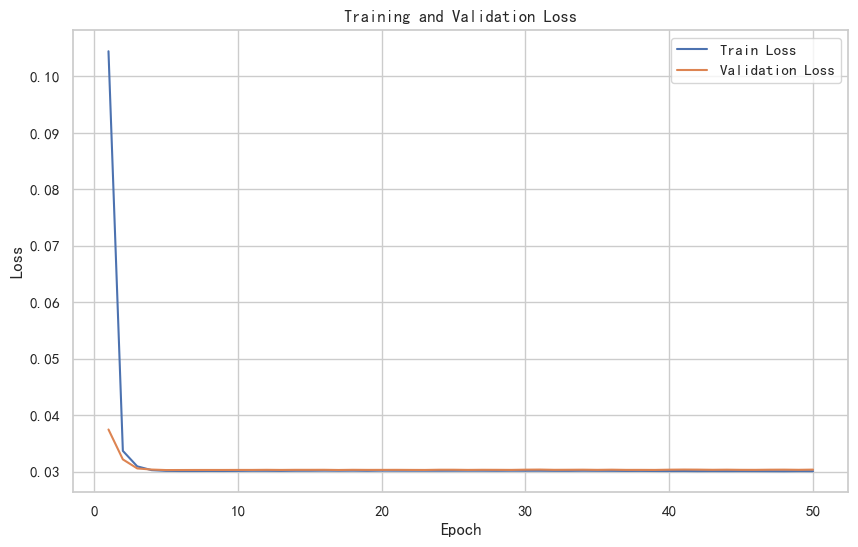

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## 7. 模型评估

In [ ]:
model.eval()
with torch.no_grad():
    y_pred = model(X)

# 转换为 NumPy 数组
y_true = y.numpy()
y_pred = y_pred.numpy()

# 反归一化
y_true = scaler.inverse_transform(y_true)
y_pred = scaler.inverse_transform(y_pred)

# 计算均方误差
mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
print(f"MSE: {mse:.2f}")

MSE: 5.99


## 8. 绘制实际值和预测值的对比图

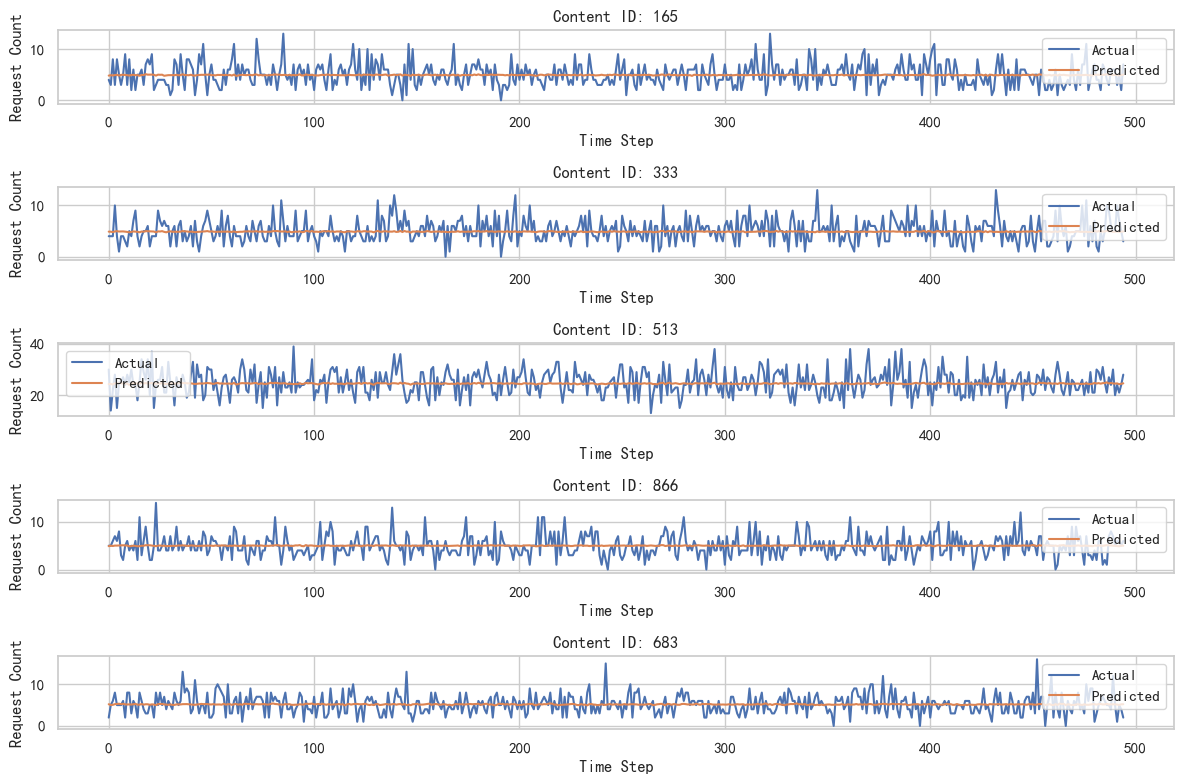

In [23]:
num_samples = 5
sample_indices = np.random.choice(num_contents, num_samples, replace=False)

y_true_samples = y_true[:, sample_indices]
y_pred_samples = y_pred[:, sample_indices]

time_axis = range(len(y_true_samples))

plt.figure(figsize=(12, 8))
for i in range(num_samples):
    plt.subplot(num_samples, 1, i + 1)
    plt.plot(time_axis, y_true_samples[:, i], label="Actual")
    plt.plot(time_axis, y_pred_samples[:, i], label="Predicted")
    plt.title(f"Content ID: {sample_indices[i]}")
    plt.xlabel("Time Step")
    plt.ylabel("Request Count")
    plt.legend()
    plt.tight_layout()
plt.show()

## 9. 绘制最后一个时间步的请求量分布

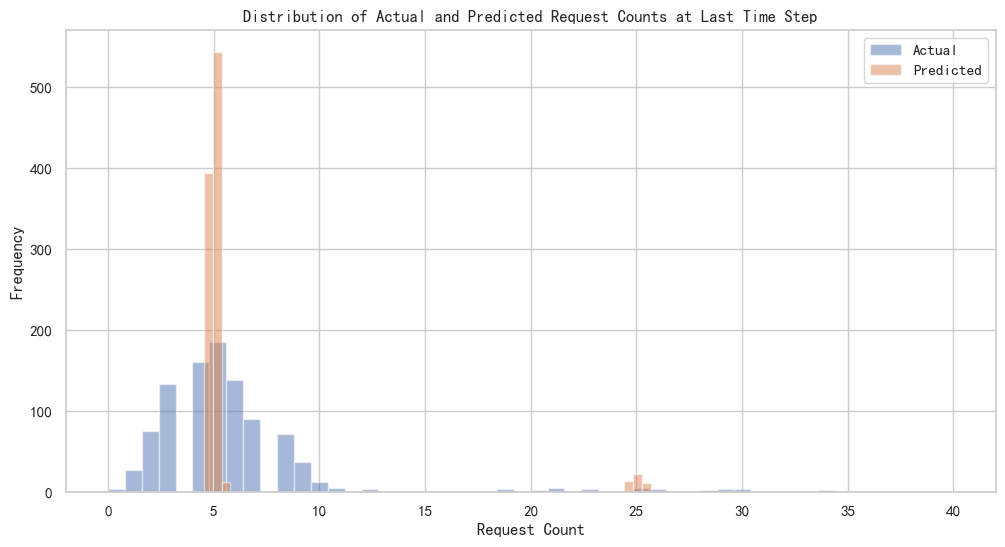

In [24]:
y_true_last = y_true[-1]
y_pred_last = y_pred[-1]

plt.figure(figsize=(12, 6))
plt.hist(y_true_last, bins=50, alpha=0.5, label="Actual")
plt.hist(y_pred_last, bins=50, alpha=0.5, label="Predicted")
plt.xlabel("Request Count")
plt.ylabel("Frequency")
plt.title("Distribution of Actual and Predicted Request Counts at Last Time Step")
plt.legend()
plt.show()

## 10. 可视化预测的热门内容

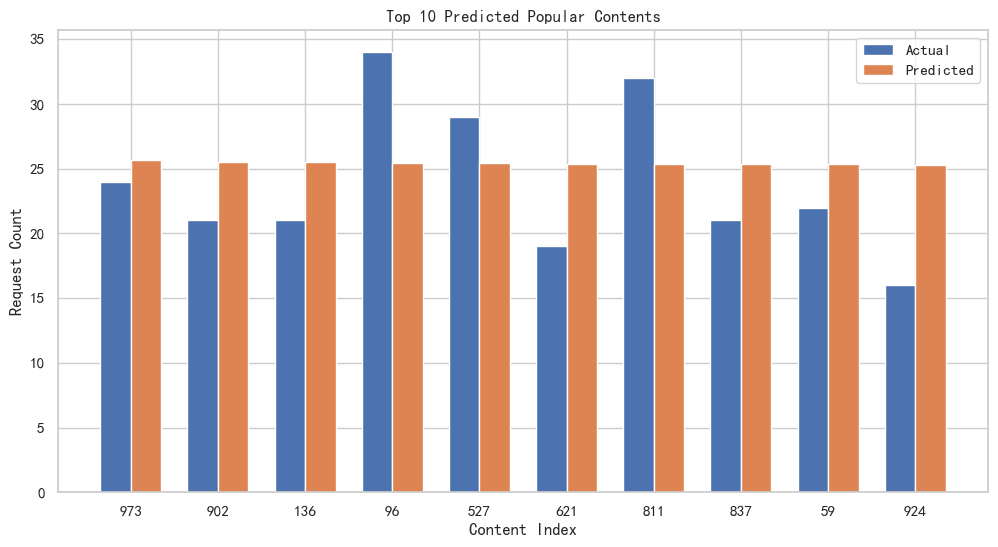

In [25]:
top_n = 10
top_indices = np.argsort(-y_pred_last)[:top_n]

top_y_true = y_true_last[top_indices]
top_y_pred = y_pred_last[top_indices]

plt.figure(figsize=(12, 6))
indices = np.arange(top_n)
width = 0.35

plt.bar(indices, top_y_true, width=width, label="Actual")
plt.bar(indices + width, top_y_pred, width=width, label="Predicted")
plt.xlabel("Content Index")
plt.ylabel("Request Count")
plt.title(f"Top {top_n} Predicted Popular Contents")
plt.xticks(indices + width / 2, top_indices)
plt.legend()
plt.show()